<h1> Predicting Housing Prices </h1>

<h2> Analysis by Mark Zusman </h2>

 In this notebook I will attempt to predict housing prices from a housing dataset.  This data set contains a ton of data fields (81 in total) of various attributes about houses.  These house attributes range form the sale price and year built to the shape of the property.  The sale price column is unique as predicting this is the goal of th Kaggle competition.  The test data set that is apart of the Kaggle competition does not contain the sale price because this is what the competiton is testing to see if you can predict it.  The eqaulation for this competition will be based on the root mean square error value (or RMSE for short).  
<br><br>
In my analysis I take a stastical approach to estimate the sale price of the houses.  I start by overviewing the data to get and idea of what the data set looks like.  My first failed attempt was to make a decison tree classifier from the sklearn package.  Since this did not work well I switched to the statistical approach I talked about earlier.  I wanted to create a linear model.  However before creating a linear model I needed to remove any columns that may overly complicate the model.  Essential, everything I add to the model should have a large effect on the sale price becuase then it will help in predicing the sale price.  To do this I calculated the pearson r and spearman r correlation values between the sale price and the other numeric varibles in the dataset.  After finding the columns with the highest correlation to the sale price column I used these to build my model.  Since the test data did not come with the Sale Price column I decided to divide up the test data into my own train and test sets.    From here I used skelarn's linear regression model to fit the highest correlated columns with the sale price of the house.  From this I was able to evaulte my model with the RMSE.  After evaluating my model I was ready to train the model with the Kaggle competition's trian set to make my final prediction in the Kaggle competition.  

In [1]:
#Python 3 environment

#==========IMPORTS=========#

#imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy.stats as stats
import sklearn
import scipy
import matplotlib as mpl
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier






In [2]:
print("Version number of packages")
print("TensorFlow v" + tf.__version__)
print("Seaborn v" + sns.__version__)
print("NumPy v" + np.__version__)
print("Pandas v" + pd.__version__)
print("Sklearn v" + sklearn.__version__)
print("SciPy v" + scipy.__version__)
print("MatPlotLib v" + mpl.__version__)

Versions of packages
TensorFlow v2.16.1
Seaborn v0.12.2
NumPy v1.26.4
Pandas v2.0.3
Sklearn v1.3.0
SciPy v1.10.1
MatPlotLib v3.7.3


## Loading in the Data

In [3]:
#reading in the data files from the competition

train = pd.read_csv(r"Data\train.csv")
test = pd.read_csv(r"Data\test.csv")
sample_submission = pd.read_csv(r"Data\sample_submission.csv")




In [4]:
#the goal of this notebook is to create a prediction of sales price for each house. 
#this is what is should look like
sample_submission.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [5]:
# train data set we will use to create our model
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
#test data set we will use to crate the sample submission file
#notice the "SalePrice" column is NOT in this dataset (because this is what we are predicting)
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Understanding the Data

In [7]:
#getting an overview of all the columns of the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


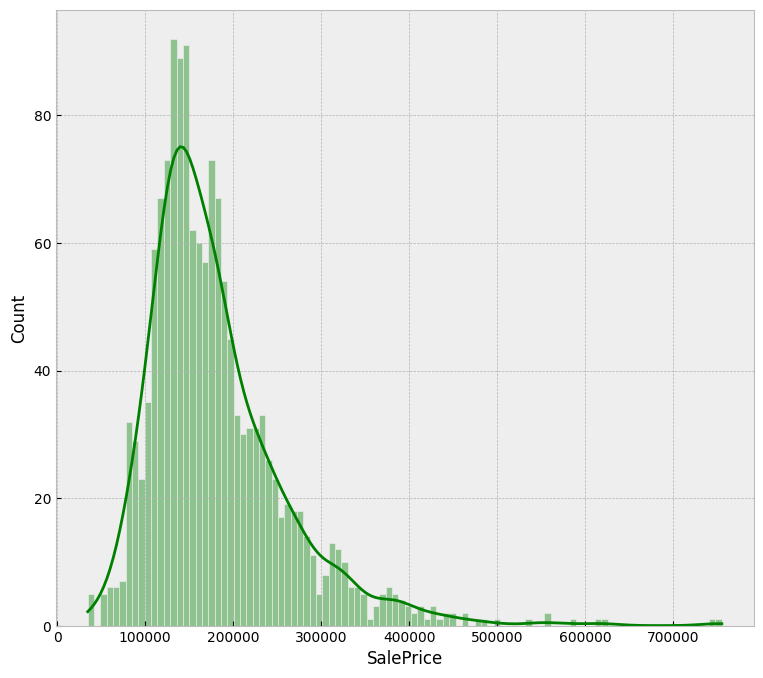

In [8]:
print(train['SalePrice'].describe())
plt.style.use('bmh')
plt.figure(figsize=(9, 8))
sns.histplot(train['SalePrice'], color='g', bins=100, alpha=0.4, kde = True)
plt.show()

In [9]:
list(set(train.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [10]:
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


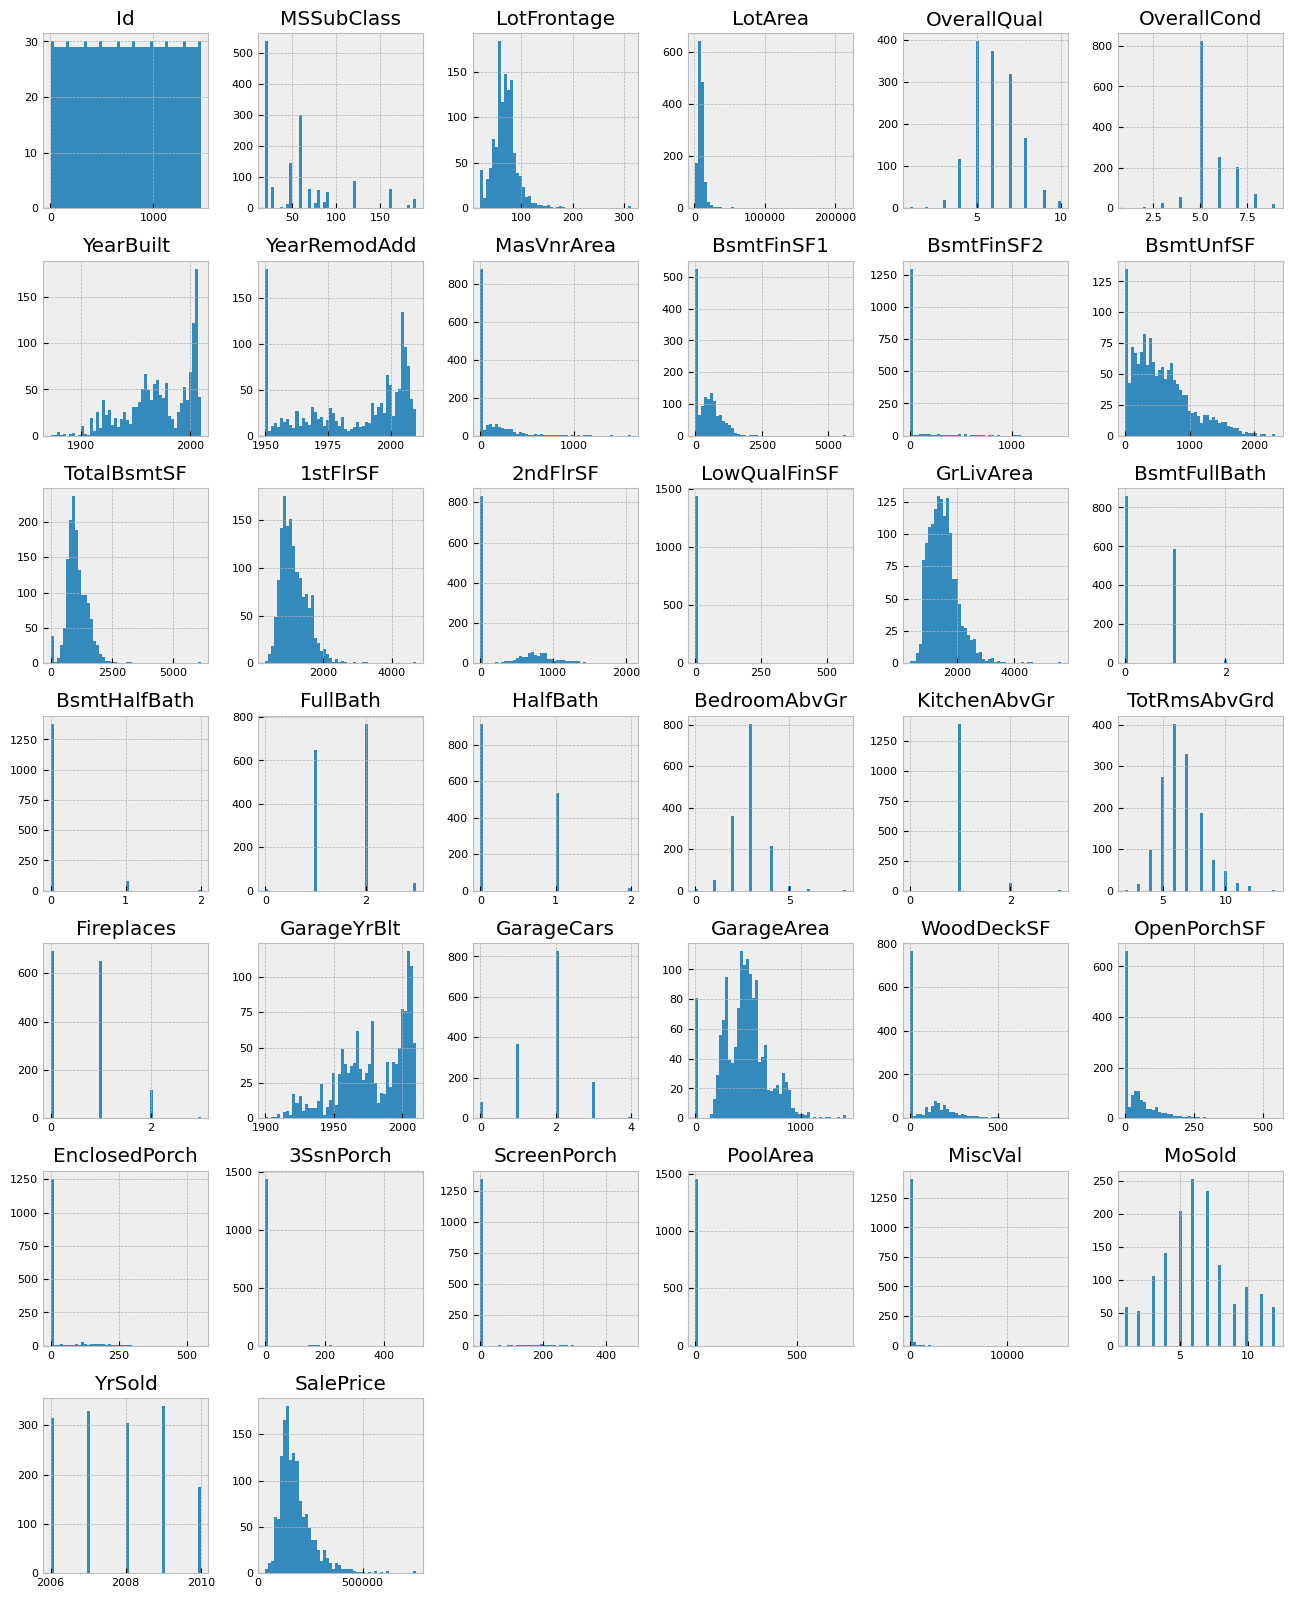

In [11]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [12]:
df_num.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [13]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


Some of the count of Null values in a columns are high>  I would consider some of these columns with the highest Null values to be uninformative.  Therefore, I will drop the entire column of data that contain more than 20% null values to avoid having large gaps of Null values.   

In [14]:
temp = train.drop(['MiscFeature','Alley', 'Fence', 'MasVnrType', 'FireplaceQu'], axis=1)
train = temp

In [15]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtQual,37,0.025342


In [16]:
#for the lack of values I will drop this column
train['PoolQC'].value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

In [17]:
#dropping the ID col for training because it is unnecesesary
#dropping other columns because of the null values
train = train.drop(['Id','PoolQC'], axis=1)

## Attempt #1 Decision Tree Classifier from `sklearn`

In [18]:

clf = DecisionTreeClassifier()

X_pred_variables = df_num[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                                                       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                                                       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                                       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                                                       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces','GarageYrBlt', 
                                                       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', 
                                                       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal','MoSold', 'YrSold']].values

y_val = df_num['SalePrice'].values

scores = cross_val_score(clf,X_pred_variables , y_val ,scoring = 'accuracy')



print("Accuracy: {0:.2f}%".format(np.mean(scores)*100))         
         
         

C:\Users\markd\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.82%


The accuracy of a sklearn decision tree classifier is less than 1%.  For modeling something this complex a simple decison tree classifier will not work.  More advanced techniques will need to be used and or more preprocessing of the data.  Inputting all of the data with very little preprocessing is not a good method to use to create a predictive model.  

## Attempt #2 Creating a model
With no luck using decision tree classifiers a linear model may explain the price of the houses better.  To start off we will use the `sns.pairplot` command form Seaborn and get an good idea of the correaltion between all the values (there is a lot of values) and we will want to select the best features of the entire set to use for our model.  
<br>
<br>
One useful thing to note when making linear models.  The quality of features included to predict the y variable (in this case the house price) is more important than the quanity of features that you use.  Therefore, the goal of this linear regression model will be to select the best features to add to the model to maximize the accuracy of the model. 
<br>
<br>
### Selecting the right columns
In the next cell I decided to calculate the pearson r value and spearman r value for the variables in the dataframe that were numeric.  I only printed out the correlatoin value if the p-value was significant and the pearson r or spearman r value was above .6.  This will give me the columns with the highest correlation.  This will allow to me create a "leaner model" to predict housing price.  

In [19]:
df_for_corr = train.select_dtypes(include = ['float64', 'int64'])

df_for_corr = df_for_corr.dropna()

#creating a set to add the final columsn to 
final_cols = set()



for row in df_for_corr:
    if row == 'SalePrice':
        continue
    pearson_ans = stats.pearsonr(df_for_corr['SalePrice'], df_for_corr[row])
    
    spearman_ans = stats.spearmanr(df_for_corr['SalePrice'], df_for_corr[row])
    
    still_print_stmt = True
    if pearson_ans.pvalue < .05 and pearson_ans.statistic > .65:
        #print("\nThe {0:} columns correlation values are:".format(row))
        print('\n',row)
        still_print_stmt = False    
        #print('The pearson correlatoin coeffeicnt is {0:.4f} with a p-value of {1:.4f}'.format(pearson_ans.statistic, pearson_ans.pvalue))
        print('pearson corr {0:.4f}'.format(pearson_ans.statistic))
        final_cols.add(row)
    if spearman_ans.pvalue < .05 and spearman_ans.statistic > .65:
        if still_print_stmt == True:
            #print("\nThe {0:} columns correlation values are:".format(row))
            print("\n",row)
        #print('The spearman correlatoin coeffeicnt is {0:.4f} with a p-value of {1:.4f}'.format(spearman_ans.statistic, spearman_ans.pvalue))
        print('spearman corr {0:.4f}'.format(spearman_ans.statistic))
        final_cols.add(row)
    

    #print(train[row])


 OverallQual
pearson corr 0.7979
spearman corr 0.8271

 YearBuilt
spearman corr 0.6702

 GrLivArea
pearson corr 0.7052
spearman corr 0.7250

 FullBath
spearman corr 0.6512

 GarageCars
spearman corr 0.6681


In [20]:
final_list = []

final_list  = list(final_cols)

for i in final_list:
    print(i)

YearBuilt
GrLivArea
GarageCars
OverallQual
FullBath


Now that the highest corrleated columns have been selected I can create a model and see how it predicts the actual price of a house 

### Splitting the data again

In [21]:
X = train[final_list]
y = train['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### building the model

In [22]:
#creating the model object
model = LinearRegression()

#fitting the model with the test data
model.fit(x_train, y_train)

LinearRegression()

### Evaluating the model

In [23]:
#printing the model's coefficents
print(model.coef_)

[  414.86036272    53.41346466 18484.11982603 22514.57552065
 -7623.15288143]


In [24]:
pd.DataFrame(model.coef_, x_train.columns, columns = ['Coeff'])

,Coeff
YearBuilt,414.860363
GrLivArea,53.413465
GarageCars,18484.119826
OverallQual,22514.575521
FullBath,-7623.152881


In [25]:
#getting the predicitons
predictions = model.predict(x_test)

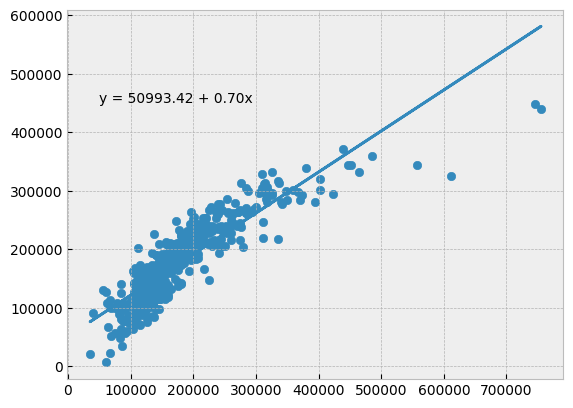

In [26]:
#scatter plot

#getting a line for the scatter plot
a, b = np.polyfit(y_test, predictions, 1)

#creating the graph of predicitons
plt.figure()

#plotting the data
plt.scatter(y_test, predictions)

#adding line of best fit
plt.plot(y_test, a*y_test+b)

#adding equation of line
plt.text(50000, 450000, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.show()

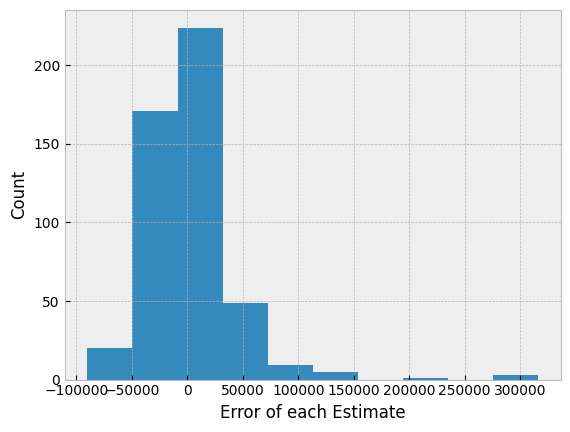

In [27]:
#plotting histogram of the true error of each prediciton

plt.figure()
plt.hist(y_test - predictions)
plt.xlabel("Error of each Estimate")
plt.ylabel('Count')
plt.show()

### Mean absolute error

In [28]:
metrics.mean_absolute_error(y_test, predictions)

26998.213736682552

### Mean Square Error

In [29]:
metrics.mean_squared_error(y_test, predictions) #1.7 B

1714148551.7763302

### Root Mean Square Error

In [30]:
rmse_val = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print(rmse_val)

41402.2771327415


### Standard Deviation

In [31]:
y_test.std()

85770.93988347209

## The Final test

After creating a model that has a good enought RMSE value we can create the final submission for the competition with the test data it gives us.  Remeber since we never had the sale price of the houses in the test dataset.  We would have been unable to evaulate how well our model did.

In [32]:

train_copy = train
test_copy = test

train_copy = train.dropna()

#ressitng the final_list variable
final_list  = list(final_cols)


x_train = train_copy[final_list]
y_train = train_copy['SalePrice']

final_list_with_id = []
for i in final_list:
    final_list_with_id.append(i)
final_list_with_id.append('Id')

x_test = test_copy[final_list_with_id]


x_test_after_dropping_nans = x_test.dropna()




#printing out the shape to ensure they are the correct shape
print(x_train.shape)
print(y_train.shape)

print('\n', x_test.shape)
print(x_test_after_dropping_nans.shape)


(1094, 5)
(1094,)

 (1459, 6)
(1458, 6)


In [33]:
#we will have to find the row with the na value

set1 = set(x_test['Id'])
set2 = set(x_test_after_dropping_nans['Id'])

row_to_delete = set1.difference(set2)

row_to_delete = 2577

print(row_to_delete)
#we will have to remember this later

2577


In [34]:
#creating the model object
model_final = LinearRegression()

#fitting the model with the test data
model_final.fit(x_train, y_train)

LinearRegression()

In [35]:
#printing out the model's coeffecients
pd.DataFrame(model.coef_, x_train.columns, columns = ['Coeff'])

,Coeff
YearBuilt,414.860363
GrLivArea,53.413465
GarageCars,18484.119826
OverallQual,22514.575521
FullBath,-7623.152881


In [36]:
#getting the predicitons
predictions = model.predict(x_test_after_dropping_nans[final_list])

In [37]:
#printing out what a sample submission should look like
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [38]:
#creating my submission
my_submission = sample_submission

In [39]:
#printing the length for my submission
len(my_submission)

1459

In [40]:
#removing a row for my submission
my_submission = sample_submission[sample_submission.Id != 2577]

In [41]:
#ensuring my submission is the right length
len(my_submission)

1458

In [42]:
#creating my submission
output = pd.DataFrame({'Id': my_submission.Id, 'SalePrice': predictions})

In [43]:
#printing my submission out
output

,Id,SalePrice
0,1461,107988.588478
1,1462,152386.613109
2,1463,172936.598078
3,1464,194530.697345
4,1465,219764.723659
...,...,...
1454,2915,81192.675469
1455,2916,99676.795296
1456,2917,143577.464350
1457,2918,106317.736281
